# Intro
In this notebook, we study two things
- The impact of the Hyperparameters on EigenFaces
- The impact of transformations on EigenFaces using the most favorable conditions

# Hyperparameters

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from vic.dataloader import load_orl, load_yale, make_fixed_test_indices, split_with_fixed_test
from vic.models import Eigenfaces

In [12]:
orl = load_orl("../data/ORL")
yale = load_yale("../data/Yale")

test_idx_orl, pool_idx_orl = make_fixed_test_indices(orl, n_test=3, seed=0)
test_idx_yale, pool_idx_yale = make_fixed_test_indices(yale, n_test=3, seed=0)

Xtr_orl, ytr_orl, Xte_orl, yte_orl = split_with_fixed_test(orl, test_idx_orl, pool_idx_orl, 7, seed=0)
Xtr_yale, ytr_yale, Xte_yale, yte_yale = split_with_fixed_test(yale, test_idx_yale, pool_idx_yale, 7, seed=0)

In [ ]:
def evaluate_eigenfaces_mean_std(
    data,
    test_idx,
    pool_idx,
    Ks,
    n_train=7,
    n_exp=10,
    seed_master=0,
):
    rng = np.random.RandomState(seed_master)

    accs = np.zeros((len(Ks), n_exp))

    for exp in tqdm(range(n_exp)):
        seed = rng.randint(0, 10_000)

        Xtr, ytr, Xte, yte = split_with_fixed_test(data, test_idx, pool_idx, n_train=n_train, seed=seed)

        for i, K in enumerate(Ks):
            model = Eigenfaces(K)
            model.fit(Xtr, ytr)
            y_pred = model.predict(Xte)
            accs[i, exp] = (y_pred == yte).mean()

    return accs.mean(axis=1), accs.std(axis=1)

In [ ]:
Ks = [5, 10, 20, 40, 80, 100]

mean_orl, std_orl = evaluate_eigenfaces_mean_std(
    orl, test_idx_orl, pool_idx_orl, Ks, n_train=7, n_exp=5, seed_master=0
)

mean_yale, std_yale = evaluate_eigenfaces_mean_std(
    yale, test_idx_yale, pool_idx_yale, Ks, n_train=7, n_exp=5, seed_master=0
)

100%|██████████| 5/5 [01:38<00:00, 19.77s/it]


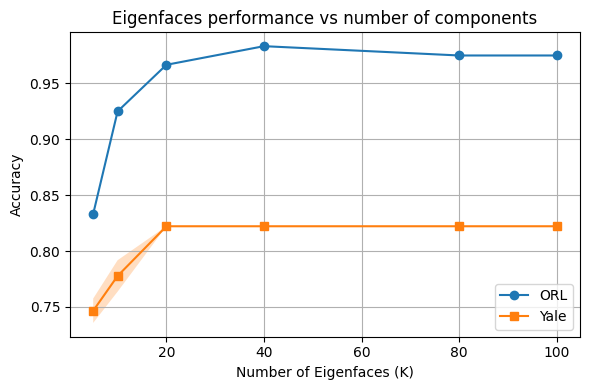

In [19]:
plt.figure(figsize=(6, 4))

# ORL
plt.plot(Ks, mean_orl, marker="o", label="ORL")
plt.fill_between(Ks, mean_orl - std_orl, mean_orl + std_orl, alpha=0.25)

# Yale
plt.plot(Ks, mean_yale, marker="s", label="Yale")
plt.fill_between(Ks, mean_yale - std_yale, mean_yale + std_yale, alpha=0.25)

plt.xlabel("Number of Eigenfaces (K)")
plt.ylabel("Accuracy")
plt.title("Eigenfaces performance vs number of components")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Transformations